# PreTrain

In [1]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 9

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.233
[2] loss: 0.135
[3] loss: 0.044
[4] loss: 0.026
[5] loss: 0.018
[6] loss: 0.013
[7] loss: 0.010
[8] loss: 0.009
[9] loss: 0.009
[10] loss: 0.006
[11] loss: 0.006
[12] loss: 0.005
[13] loss: 0.005
[14] loss: 0.003
[15] loss: 0.001
[16] loss: 0.007
[17] loss: 0.003
[18] loss: 0.003
[19] loss: 0.004
[20] loss: 0.003


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 9])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

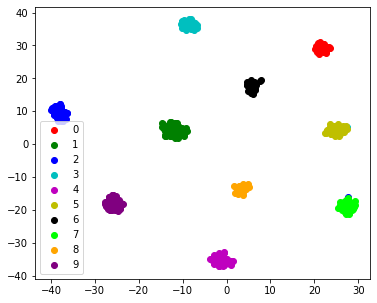

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

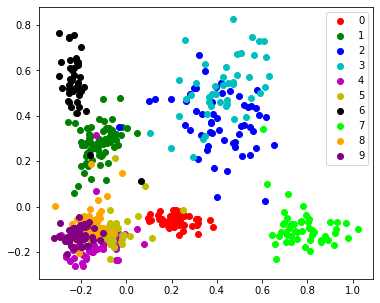

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [12]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[ 0.2031, -0.1235,  0.4026,  0.4340, -0.1638, -0.0715, -0.2262,  0.7674,
         -0.1672, -0.2132],
        [-0.2212, -0.1471,  0.3691, -0.3014,  0.3457, -0.2772, -0.1820, -0.2264,
          0.4577, -0.2041],
        [-0.0666,  0.2923,  0.3417,  0.5432, -0.1916, -0.0977,  0.5485, -0.1118,
         -0.0611, -0.1219],
        [ 0.3612, -0.2004,  0.2486,  0.2548, -0.2507, -0.2213, -0.1921, -0.2367,
         -0.0816,  0.3857],
        [-0.1987, -0.2233,  0.2494, -0.2396,  0.2057,  0.4363,  0.1690, -0.2520,
         -0.3077,  0.0445],
        [-0.1697,  0.4207, -0.3179,  0.4279, -0.2064,  0.4274, -0.1954, -0.2111,
          0.4176, -0.1640],
        [-0.1797,  0.2364, -0.3648,  0.4088, -0.2683,  0.5224, -0.1926, -0.2063,
          0.3673, -0.1619],
        [ 0.3983,  0.4113, -0.1714, -0.2174,  0.4733, -0.1517,  0.3037, -0.1748,
         -0.1385, -0.1636],
        [-0.1996,  0.4546, -0.1379, -0.1152,  0.2029, -0.1358, -0.1827,  0.4087,
         -0.1003,  0.5096]])

In [13]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}.pt')

In [14]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [15]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [16]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,y_dim,y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}.pt')

# Train

In [17]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_14.cfg')

['./config/sswae_dev2_1_14.cfg']

In [18]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 4
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 9
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.454881e-01  D: 6.923650e-01  D2: 5.405382e-02  D3: 3.823881e-03
test loss: 1.872319e-01  D: 7.020024e-01  D2: 1.395831e-02  D3: 9.585273e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.630344e-01  D: 6.932145e-01  D2: 8.390493e-03  D3: 8.138020e-03
test loss: 1.460960e-01  D: 6.927930e-01  D2: 4.504108e-03  D3: 7.663241e-03


[default |INFO|model.py:1280] [03/80]  loss: 1.424579e-01  D: 6.935228e-01  D2: 2.198451e-03  D3: 8.564790e-03
test loss: 1.295868e-01  D: 6.935907e-01  D2: -8.463001e-04  D3: 8.152264e-03


[default |INFO|model.py:1280] [04/80]  loss: 1.220250e-01  D: 6.982015e-01  D2: -9.166161e-04  D3: 1.048356e-02
test loss: 1.176620e-01  D: 6.647578e-01  D2: -9.403801e-04  D3: 1.402589e-02


[default |INFO|model.py:1280] [05/80]  loss: 1.027216e-01  D: 6.939373e-01  D2: -1.682792e-03  D3: 1.305052e-02
test loss: 9.509678e-02  D: 6.527202e-01  D2: -2.010241e-03  D3: 1.442946e-02


[default |INFO|model.py:1280] [06/80]  loss: 9.337714e-02  D: 6.946621e-01  D2: -2.182606e-03  D3: 1.562755e-02
test loss: 8.774753e-02  D: 7.298169e-01  D2: -1.797380e-03  D3: 1.770028e-02


[default |INFO|model.py:1280] [07/80]  loss: 8.521468e-02  D: 6.953798e-01  D2: -2.989143e-03  D3: 1.509079e-02
test loss: 7.858438e-02  D: 6.747282e-01  D2: -2.840891e-03  D3: 1.238047e-02


[default |INFO|model.py:1280] [08/80]  loss: 7.845453e-02  D: 6.942404e-01  D2: -3.460315e-03  D3: 1.373870e-02
test loss: 8.102815e-02  D: 7.243032e-01  D2: -3.767262e-03  D3: 1.835518e-02


[default |INFO|model.py:1280] [09/80]  loss: 7.371403e-02  D: 6.940255e-01  D2: -3.624427e-03  D3: 1.421758e-02
test loss: 7.062853e-02  D: 7.036600e-01  D2: -3.335447e-03  D3: 1.352098e-02


[default |INFO|model.py:1280] [10/80]  loss: 6.953545e-02  D: 6.941688e-01  D2: -3.941704e-03  D3: 1.439119e-02
test loss: 6.803437e-02  D: 7.069193e-01  D2: -4.457064e-03  D3: 1.569121e-02


[default |INFO|model.py:1280] [11/80]  loss: 6.725946e-02  D: 6.936703e-01  D2: -3.989647e-03  D3: 1.479928e-02
test loss: 6.619734e-02  D: 6.924134e-01  D2: -4.788265e-03  D3: 1.527826e-02


[default |INFO|model.py:1280] [12/80]  loss: 6.501436e-02  D: 6.935696e-01  D2: -4.403416e-03  D3: 1.444023e-02
test loss: 6.476405e-02  D: 6.895920e-01  D2: -4.603128e-03  D3: 1.433237e-02


[default |INFO|model.py:1280] [13/80]  loss: 6.392354e-02  D: 6.939649e-01  D2: -4.770247e-03  D3: 1.409649e-02
test loss: 6.167736e-02  D: 6.981630e-01  D2: -4.755783e-03  D3: 1.506113e-02


[default |INFO|model.py:1280] [14/80]  loss: 6.198988e-02  D: 6.934927e-01  D2: -4.757881e-03  D3: 1.400236e-02
test loss: 6.005977e-02  D: 6.903113e-01  D2: -5.164289e-03  D3: 1.350762e-02


[default |INFO|model.py:1280] [15/80]  loss: 6.165976e-02  D: 6.934362e-01  D2: -5.044058e-03  D3: 1.411766e-02
test loss: 6.172698e-02  D: 7.084011e-01  D2: -5.138874e-03  D3: 1.527532e-02


[default |INFO|model.py:1280] [16/80]  loss: 6.039715e-02  D: 6.940628e-01  D2: -5.055437e-03  D3: 1.396765e-02
test loss: 5.864764e-02  D: 7.034984e-01  D2: -5.332775e-03  D3: 1.375192e-02


[default |INFO|model.py:1280] [17/80]  loss: 5.952736e-02  D: 6.935588e-01  D2: -5.329639e-03  D3: 1.354656e-02
test loss: 5.947280e-02  D: 6.823923e-01  D2: -4.786015e-03  D3: 1.431868e-02


[default |INFO|model.py:1280] [18/80]  loss: 5.851829e-02  D: 6.934551e-01  D2: -5.045764e-03  D3: 1.411736e-02
test loss: 5.845963e-02  D: 7.028588e-01  D2: -5.665264e-03  D3: 1.357573e-02


[default |INFO|model.py:1280] [19/80]  loss: 5.766808e-02  D: 6.938932e-01  D2: -5.667129e-03  D3: 1.375193e-02
test loss: 5.695787e-02  D: 6.766262e-01  D2: -4.285011e-03  D3: 1.444009e-02


[default |INFO|model.py:1280] [20/80]  loss: 5.671844e-02  D: 6.943395e-01  D2: -5.452490e-03  D3: 1.368658e-02
test loss: 5.727458e-02  D: 7.063736e-01  D2: -4.729919e-03  D3: 1.359320e-02


[default |INFO|model.py:1280] [21/80]  loss: 5.575020e-02  D: 6.931423e-01  D2: -5.659583e-03  D3: 1.383493e-02
test loss: 5.689576e-02  D: 6.833124e-01  D2: -5.751734e-03  D3: 1.338267e-02


[default |INFO|model.py:1280] [22/80]  loss: 5.564136e-02  D: 6.929094e-01  D2: -5.966768e-03  D3: 1.349022e-02
test loss: 5.764662e-02  D: 7.021389e-01  D2: -6.001396e-03  D3: 1.353180e-02


[default |INFO|model.py:1280] [23/80]  loss: 5.542279e-02  D: 6.926514e-01  D2: -6.081502e-03  D3: 1.350808e-02
test loss: 5.606032e-02  D: 6.939403e-01  D2: -6.050320e-03  D3: 1.353097e-02


[default |INFO|model.py:1280] [24/80]  loss: 5.376902e-02  D: 6.933990e-01  D2: -5.910287e-03  D3: 1.369237e-02
test loss: 5.395502e-02  D: 7.010401e-01  D2: -5.351973e-03  D3: 1.368125e-02


[default |INFO|model.py:1280] [25/80]  loss: 5.382607e-02  D: 6.937914e-01  D2: -6.231697e-03  D3: 1.354481e-02
test loss: 5.685164e-02  D: 6.864138e-01  D2: -6.122398e-03  D3: 1.228632e-02


[default |INFO|model.py:1280] [26/80]  loss: 5.418771e-02  D: 6.937696e-01  D2: -6.165786e-03  D3: 1.337941e-02
test loss: 5.490693e-02  D: 6.940025e-01  D2: -6.280260e-03  D3: 1.395844e-02


[default |INFO|model.py:1280] [27/80]  loss: 5.331498e-02  D: 6.932304e-01  D2: -6.320796e-03  D3: 1.347813e-02
test loss: 5.470566e-02  D: 6.728133e-01  D2: -6.539106e-03  D3: 1.353249e-02


[default |INFO|model.py:1280] [28/80]  loss: 5.306092e-02  D: 6.942871e-01  D2: -6.441100e-03  D3: 1.345292e-02
test loss: 5.317338e-02  D: 6.986733e-01  D2: -6.676579e-03  D3: 1.175173e-02


[default |INFO|model.py:1280] [29/80]  loss: 5.229124e-02  D: 6.934188e-01  D2: -6.555904e-03  D3: 1.341988e-02
test loss: 5.327431e-02  D: 6.950758e-01  D2: -5.567636e-03  D3: 1.425189e-02


[default |INFO|model.py:1280] [30/80]  loss: 5.148428e-02  D: 6.934181e-01  D2: -6.703038e-03  D3: 1.336825e-02
test loss: 5.240893e-02  D: 6.871319e-01  D2: -6.666718e-03  D3: 1.370415e-02


[default |INFO|model.py:1280] [31/80]  loss: 5.138771e-02  D: 6.933927e-01  D2: -6.640693e-03  D3: 1.355084e-02
test loss: 5.333125e-02  D: 7.027871e-01  D2: -7.055235e-03  D3: 1.346127e-02


[default |INFO|model.py:1280] [32/80]  loss: 5.215534e-02  D: 6.938393e-01  D2: -6.866603e-03  D3: 1.314605e-02
test loss: 5.358385e-02  D: 6.877091e-01  D2: -6.455441e-03  D3: 1.277312e-02


[default |INFO|model.py:1280] [33/80]  loss: 5.155559e-02  D: 6.933956e-01  D2: -6.933355e-03  D3: 1.316494e-02
test loss: 5.157457e-02  D: 7.099929e-01  D2: -6.684494e-03  D3: 1.342005e-02


[default |INFO|model.py:1280] [34/80]  loss: 5.088089e-02  D: 6.932456e-01  D2: -6.934737e-03  D3: 1.330067e-02
test loss: 5.205870e-02  D: 6.921122e-01  D2: -7.352858e-03  D3: 1.328653e-02


[default |INFO|model.py:1280] [35/80]  loss: 5.123361e-02  D: 6.933144e-01  D2: -7.136504e-03  D3: 1.305020e-02
test loss: 5.382701e-02  D: 6.904985e-01  D2: -7.153635e-03  D3: 1.277179e-02


[default |INFO|model.py:1280] [36/80]  loss: 5.074571e-02  D: 6.943136e-01  D2: -7.168832e-03  D3: 1.313177e-02
test loss: 5.126308e-02  D: 6.925292e-01  D2: -7.765532e-03  D3: 1.184945e-02


[default |INFO|model.py:1280] [37/80]  loss: 5.041828e-02  D: 6.931842e-01  D2: -7.363338e-03  D3: 1.321047e-02
test loss: 5.255032e-02  D: 6.897157e-01  D2: -7.243204e-03  D3: 1.283356e-02


[default |INFO|model.py:1280] [38/80]  loss: 5.072678e-02  D: 6.937457e-01  D2: -7.589796e-03  D3: 1.298302e-02
test loss: 5.058590e-02  D: 6.912059e-01  D2: -7.336588e-03  D3: 1.233123e-02


[default |INFO|model.py:1280] [39/80]  loss: 5.024168e-02  D: 6.935161e-01  D2: -7.600390e-03  D3: 1.302453e-02
test loss: 5.253540e-02  D: 6.910262e-01  D2: -7.303648e-03  D3: 1.345328e-02


[default |INFO|model.py:1280] [40/80]  loss: 4.973261e-02  D: 6.930151e-01  D2: -7.485706e-03  D3: 1.304803e-02
test loss: 5.363500e-02  D: 6.917919e-01  D2: -7.575684e-03  D3: 1.222178e-02


[default |INFO|model.py:1280] [41/80]  loss: 4.994908e-02  D: 6.933306e-01  D2: -7.764591e-03  D3: 1.294680e-02
test loss: 5.144547e-02  D: 6.852137e-01  D2: -7.776814e-03  D3: 1.234848e-02


[default |INFO|model.py:1280] [42/80]  loss: 4.918384e-02  D: 6.937341e-01  D2: -7.753018e-03  D3: 1.302199e-02
test loss: 5.070987e-02  D: 6.998811e-01  D2: -7.658501e-03  D3: 1.285497e-02


[default |INFO|model.py:1280] [43/80]  loss: 4.929046e-02  D: 6.931377e-01  D2: -7.828331e-03  D3: 1.295104e-02
test loss: 5.132686e-02  D: 6.906089e-01  D2: -7.965984e-03  D3: 1.191094e-02


[default |INFO|model.py:1280] [44/80]  loss: 4.928842e-02  D: 6.931035e-01  D2: -7.818368e-03  D3: 1.301144e-02
test loss: 5.165731e-02  D: 7.051863e-01  D2: -7.824955e-03  D3: 1.369332e-02


[default |INFO|model.py:1280] [45/80]  loss: 4.979098e-02  D: 6.935096e-01  D2: -7.997386e-03  D3: 1.260565e-02
test loss: 5.082930e-02  D: 7.131617e-01  D2: -7.926979e-03  D3: 1.238879e-02


[default |INFO|model.py:1280] [46/80]  loss: 4.960325e-02  D: 6.933426e-01  D2: -7.955198e-03  D3: 1.273652e-02
test loss: 5.037361e-02  D: 6.942315e-01  D2: -7.886028e-03  D3: 1.343261e-02


[default |INFO|model.py:1280] [47/80]  loss: 4.927471e-02  D: 6.934665e-01  D2: -7.995571e-03  D3: 1.270042e-02
test loss: 5.172629e-02  D: 6.984994e-01  D2: -7.600002e-03  D3: 1.274792e-02


[default |INFO|model.py:1280] [48/80]  loss: 4.910690e-02  D: 6.930133e-01  D2: -8.174515e-03  D3: 1.273546e-02
test loss: 5.093834e-02  D: 6.933200e-01  D2: -8.401203e-03  D3: 1.189716e-02


[default |INFO|model.py:1280] [49/80]  loss: 4.947636e-02  D: 6.930056e-01  D2: -8.158762e-03  D3: 1.261214e-02
test loss: 5.164438e-02  D: 6.879333e-01  D2: -8.085155e-03  D3: 1.343242e-02


[default |INFO|model.py:1280] [50/80]  loss: 4.886734e-02  D: 6.942378e-01  D2: -8.242324e-03  D3: 1.271699e-02
test loss: 5.048472e-02  D: 6.890470e-01  D2: -8.159876e-03  D3: 1.120372e-02


[default |INFO|model.py:1280] [51/80]  loss: 4.861313e-02  D: 6.932515e-01  D2: -8.213180e-03  D3: 1.263341e-02
test loss: 4.950456e-02  D: 6.870008e-01  D2: -8.162909e-03  D3: 1.322623e-02


[default |INFO|model.py:1280] [52/80]  loss: 4.807057e-02  D: 6.934133e-01  D2: -8.322829e-03  D3: 1.274853e-02
test loss: 5.065157e-02  D: 6.910552e-01  D2: -8.414736e-03  D3: 1.167919e-02


[default |INFO|model.py:1280] [53/80]  loss: 4.853313e-02  D: 6.922144e-01  D2: -8.376830e-03  D3: 1.272787e-02
test loss: 5.009344e-02  D: 6.999268e-01  D2: -8.837032e-03  D3: 1.214438e-02


[default |INFO|model.py:1280] [54/80]  loss: 4.848767e-02  D: 6.935254e-01  D2: -8.394734e-03  D3: 1.261421e-02
test loss: 4.990699e-02  D: 6.936670e-01  D2: -8.183002e-03  D3: 1.230838e-02


[default |INFO|model.py:1280] [55/80]  loss: 4.847601e-02  D: 6.924939e-01  D2: -8.429670e-03  D3: 1.266249e-02
test loss: 5.026535e-02  D: 6.910085e-01  D2: -7.962046e-03  D3: 1.280197e-02


[default |INFO|model.py:1280] [56/80]  loss: 4.897338e-02  D: 6.942436e-01  D2: -8.560228e-03  D3: 1.232500e-02
test loss: 5.123478e-02  D: 6.933959e-01  D2: -8.640728e-03  D3: 1.210863e-02


[default |INFO|model.py:1280] [57/80]  loss: 4.845167e-02  D: 6.930693e-01  D2: -8.620842e-03  D3: 1.256296e-02
test loss: 5.067310e-02  D: 7.000775e-01  D2: -8.418655e-03  D3: 1.255440e-02


[default |INFO|model.py:1280] [58/80]  loss: 4.816108e-02  D: 6.929048e-01  D2: -8.563708e-03  D3: 1.266445e-02
test loss: 4.995446e-02  D: 6.905346e-01  D2: -8.414688e-03  D3: 1.262309e-02


[default |INFO|model.py:1280] [59/80]  loss: 4.780831e-02  D: 6.933753e-01  D2: -8.743337e-03  D3: 1.245144e-02
test loss: 5.007524e-02  D: 7.053776e-01  D2: -8.784399e-03  D3: 1.148848e-02


[default |INFO|model.py:1280] [60/80]  loss: 4.799688e-02  D: 6.930744e-01  D2: -8.717438e-03  D3: 1.248456e-02
test loss: 5.083725e-02  D: 7.001705e-01  D2: -9.108877e-03  D3: 1.145343e-02


[default |INFO|model.py:1280] [61/80]  loss: 4.773599e-02  D: 6.934017e-01  D2: -8.734255e-03  D3: 1.237801e-02
test loss: 4.894487e-02  D: 7.046710e-01  D2: -8.961668e-03  D3: 1.174655e-02


[default |INFO|model.py:1280] [62/80]  loss: 4.847334e-02  D: 6.933089e-01  D2: -8.713603e-03  D3: 1.229042e-02
test loss: 4.906474e-02  D: 6.861382e-01  D2: -8.881083e-03  D3: 1.250452e-02


[default |INFO|model.py:1280] [63/80]  loss: 4.775650e-02  D: 6.935997e-01  D2: -8.785934e-03  D3: 1.242429e-02
test loss: 5.003826e-02  D: 6.880381e-01  D2: -8.826342e-03  D3: 1.198203e-02


[default |INFO|model.py:1280] [64/80]  loss: 4.742663e-02  D: 6.933380e-01  D2: -8.893339e-03  D3: 1.245990e-02
test loss: 4.853481e-02  D: 7.008320e-01  D2: -8.963289e-03  D3: 1.275638e-02


[default |INFO|model.py:1280] [65/80]  loss: 4.744787e-02  D: 6.934846e-01  D2: -8.848856e-03  D3: 1.246331e-02
test loss: 5.063435e-02  D: 6.952389e-01  D2: -9.047604e-03  D3: 1.239498e-02


[default |INFO|model.py:1280] [66/80]  loss: 4.737724e-02  D: 6.932424e-01  D2: -8.892666e-03  D3: 1.232143e-02
test loss: 4.948956e-02  D: 6.945097e-01  D2: -8.952341e-03  D3: 1.261016e-02


[default |INFO|model.py:1280] [67/80]  loss: 4.713896e-02  D: 6.932344e-01  D2: -8.993416e-03  D3: 1.240349e-02
test loss: 5.084518e-02  D: 6.854698e-01  D2: -8.504572e-03  D3: 1.209758e-02


[default |INFO|model.py:1280] [68/80]  loss: 4.769017e-02  D: 6.932237e-01  D2: -9.025110e-03  D3: 1.225616e-02
test loss: 5.048914e-02  D: 6.945735e-01  D2: -9.046535e-03  D3: 1.193461e-02


[default |INFO|model.py:1280] [69/80]  loss: 4.681093e-02  D: 6.930338e-01  D2: -9.164116e-03  D3: 1.239318e-02
test loss: 5.149684e-02  D: 6.913581e-01  D2: -8.616629e-03  D3: 1.218200e-02


[default |INFO|model.py:1280] [70/80]  loss: 4.709433e-02  D: 6.934431e-01  D2: -9.132045e-03  D3: 1.224533e-02
test loss: 4.964587e-02  D: 6.930607e-01  D2: -9.221001e-03  D3: 1.117892e-02


[default |INFO|model.py:1280] [71/80]  loss: 4.692375e-02  D: 6.931169e-01  D2: -9.127278e-03  D3: 1.229382e-02
test loss: 4.934286e-02  D: 6.832276e-01  D2: -8.631363e-03  D3: 1.244070e-02


[default |INFO|model.py:1280] [72/80]  loss: 4.693687e-02  D: 6.934107e-01  D2: -9.206381e-03  D3: 1.221363e-02
test loss: 5.039993e-02  D: 6.979495e-01  D2: -9.021063e-03  D3: 1.192092e-02


[default |INFO|model.py:1280] [73/80]  loss: 4.727183e-02  D: 6.931859e-01  D2: -9.132047e-03  D3: 1.215265e-02
test loss: 4.986043e-02  D: 6.861773e-01  D2: -9.281902e-03  D3: 1.233811e-02


[default |INFO|model.py:1280] [74/80]  loss: 4.643788e-02  D: 6.933341e-01  D2: -9.307505e-03  D3: 1.223509e-02
test loss: 5.020078e-02  D: 6.928280e-01  D2: -9.326954e-03  D3: 1.206854e-02


[default |INFO|model.py:1280] [75/80]  loss: 4.681860e-02  D: 6.938359e-01  D2: -9.331474e-03  D3: 1.209000e-02
test loss: 5.035075e-02  D: 6.969346e-01  D2: -9.245968e-03  D3: 1.199621e-02


[default |INFO|model.py:1280] [76/80]  loss: 4.663148e-02  D: 6.930135e-01  D2: -9.249673e-03  D3: 1.219069e-02
test loss: 4.894018e-02  D: 6.953573e-01  D2: -9.225349e-03  D3: 1.250185e-02


[default |INFO|model.py:1280] [77/80]  loss: 4.659243e-02  D: 6.934447e-01  D2: -9.314586e-03  D3: 1.216043e-02
test loss: 5.004438e-02  D: 6.981414e-01  D2: -9.050150e-03  D3: 1.190939e-02


[default |INFO|model.py:1280] [78/80]  loss: 4.646106e-02  D: 6.931997e-01  D2: -9.275935e-03  D3: 1.211547e-02
test loss: 4.839338e-02  D: 6.876293e-01  D2: -9.326267e-03  D3: 1.285057e-02


[default |INFO|model.py:1280] [79/80]  loss: 4.617210e-02  D: 6.931882e-01  D2: -9.374042e-03  D3: 1.218493e-02
test loss: 4.953507e-02  D: 6.920701e-01  D2: -9.496937e-03  D3: 1.193148e-02


[default |INFO|model.py:1280] [80/80]  loss: 4.599148e-02  D: 6.932301e-01  D2: -9.397082e-03  D3: 1.216040e-02
test loss: 4.936255e-02  D: 6.924337e-01  D2: -9.598951e-03  D3: 1.179260e-02


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 2911.174s


# Test

In [19]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [20]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [21]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

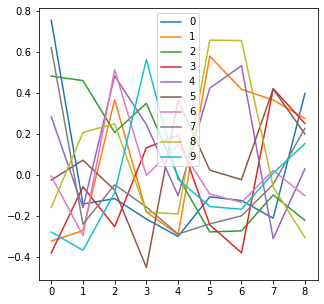

In [22]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

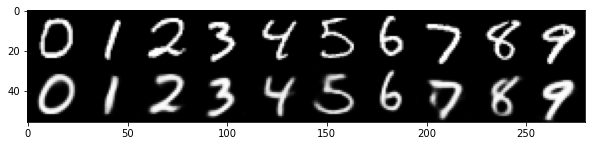

In [23]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [24]:
from XAE.sampler import gaus

exn = 5

In [25]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

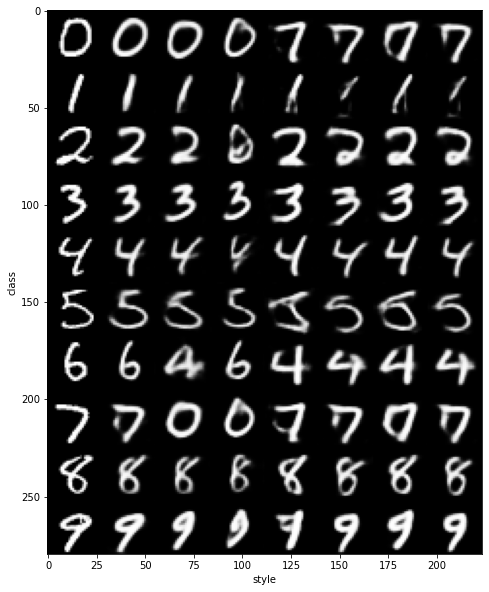

In [26]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [27]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

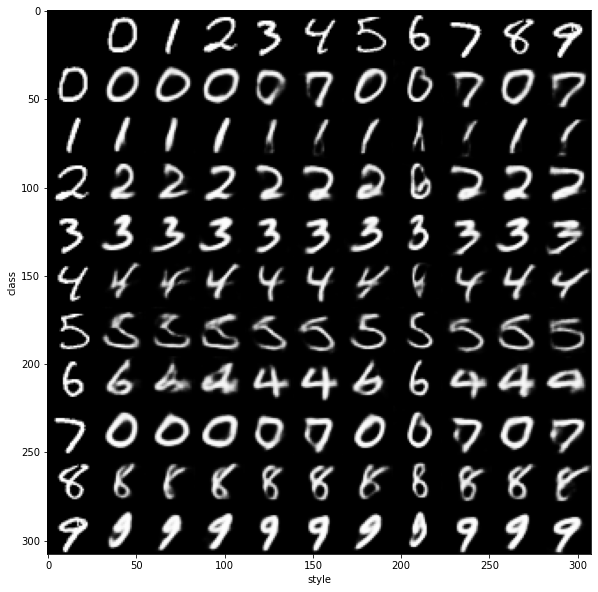

In [28]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()